This kernel is an abstractive text summarizer that attempts to create novel summaries of Covid-19 research articles. We train on articles using their abstracts as targets, test on articles without abstracts. 

*** Colab crashes if articles are over 1000 in length. only 18% of the articles are < 1000. this is a problem***
- ideas:
  - pay for a better service
  - split the articles into batches of len 800 and give them the same abstract
    - frank had the idea that we would have to put the snippets back together. 
    - test with splits of 800 and compare to performance if we recombine the snippets.
  - try on local machine before paying for anything


# Imports

In [ ]:
import tensorflow as tf
import numpy as np
import nltk
import pandas as pd 
import re
import json
import os
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Layer, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data0=pd.read_csv('/content/drive/Shared drives/Abstractive Text Summarization/data.csv')
data1=pd.read_csv('/content/drive/Shared drives/Abstractive Text Summarization/data_b1.csv')
data2=pd.read_csv('/content/drive/Shared drives/Abstractive Text Summarization/data_b2.csv')
data3=pd.read_csv('/content/drive/Shared drives/Abstractive Text Summarization/data_b3.csv')
data4=pd.read_csv('/content/drive/Shared drives/Abstractive Text Summarization/data_b4.csv')
data5=pd.read_csv('/content/drive/Shared drives/Abstractive Text Summarization/data_b5.csv')
data6=pd.read_csv('/content/drive/Shared drives/Abstractive Text Summarization/data_b6.csv')
data7=pd.read_csv('/content/drive/Shared drives/Abstractive Text Summarization/data_b7.csv')
data8=pd.read_csv('/content/drive/Shared drives/Abstractive Text Summarization/data_bL.csv')


In [ ]:
frames = [data0,data1,data2,data3,data4,data5,data6,data7,data8]

In [ ]:
data = pd.concat(frames)

In [ ]:
del data0, data1, data2, data3, data4, data5, data6, data7, data8, frames

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14126 entries, 0 to 2045
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       14126 non-null  int64 
 1   Text             14126 non-null  object
 2   Summary          14126 non-null  object
 3   cleaned_text     14126 non-null  object
 4   cleaned_summary  14126 non-null  object
dtypes: int64(1), object(4)
memory usage: 662.2+ KB


# Covid19Sum Dataset

## The metadata

In [ ]:
# data_dir = "/content/drive/Shared drives/Abstractive Text Summarization/metadata.csv"
# meta=pd.read_csv(data_dir)

## Data collection and preprocessing

The pdf articles have abstracts, while the xml articles do not.

In [ ]:
# #PDF articles (for training)
# os.chdir("/content/drive/Shared drives/Covid Summary Data/covid sum sample pdf")
# print(len(os.listdir()))

In [ ]:
#XML articles (for testing)
# os.chdir("/content/drive/Shared drives/Abstractive Text Summarization/covid sum sample")
# os.listdir()

Here we parse the body of the articles and the abstracts

In [ ]:
# #articles for train
# articles_abstract = list()
# articles_body = list()
# for i in os.listdir():
#  # print(i)
#   with open(i) as json_file:
#     itemDataPDF = json.load(json_file)
#     text_collection_body = ""
#     text_collection_abstract = ""
#     for body_text in itemDataPDF['body_text']:
#       # cov_test1.append(text['text'])
#      # print(body_text['text'])
#       text_collection_body = text_collection_body + body_text["text"]
#     for abs_text in itemDataPDF['abstract']:
#      # print(abs_text['text'])
#       text_collection_abstract = text_collection_abstract + abs_text['text']
#   articles_body.append(text_collection_body)
#   articles_abstract.append(text_collection_abstract)

#   # break;
# # with open('PMC442122.xml.json') as json_file:
# #     itemData = json.load(json_file)


In [ ]:
# print(articles_abstract[1])

In [ ]:
#the body still has the section attatched. need to remove
# print(articles_body[1])

In [ ]:
# #checking that number of articles and abstracts match 
# #if they do not match, more processing is needed
# print('number of abstracts',len(articles_abstract))
# print('number of articles',len(articles_body))

In [ ]:
#change to np array
# articles = np.array(articles_body)
# summary = np.array(articles_abstract)

# AttentionLayer

In [ ]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

# Creating Dataframe

In [ ]:
# #creates "nice" string? not sure if this is necessary
# def to_string_trim(line):
#   return str(line)[2:-2]

In [ ]:
# X_test = np.array(list(map(to_string_trim, np.array(articles_body))))
# y_test = np.array(list(map(to_string_trim, np.array(articles_abstract))))

In [ ]:
# X_test = np.array(list(map(to_string_trim, articles)))
# y_test = np.array(list(map(to_string_trim, summary)))


In [ ]:
# data = pd.DataFrame({"Text":X_test, "Summary":y_test})

In [ ]:
# data.info()

# Preprocessing


Some of the preprocessing may be redundant. Not sure if contraction_mapping is necssary, research articles shouldn't have many contractions.

In [ ]:
# contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
#                            "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
#                            "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
#                            "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
#                            "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
#                            "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
#                            "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
#                            "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
#                            "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
#                            "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
#                            "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
#                            "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
#                            "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
#                            "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
#                            "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
#                            "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
#                            "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
#                            "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
#                            "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
#                            "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
#                            "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
#                            "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
#                            "you're": "you are", "you've": "you have"}

In [ ]:
# #removes HTML tags no necessary, contraction mapping?,
# # remove('s) and parenthesis may be useful
# import nltk
# nltk.download('stopwords')

# stop_words = set(stopwords.words('english')) 

# def text_cleaner(text,num):
#     newString = text.lower()
#     newString = BeautifulSoup(newString, "lxml").text
#     newString = re.sub(r'\([^)]*\)', '', newString)
#     newString = re.sub('"','', newString)
#     newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
#     newString = re.sub(r"'s\b","",newString)
#     newString = re.sub("[^a-zA-Z]", " ", newString) 
#     newString = re.sub('[m]{2,}', 'mm', newString)
#     if(num==0):
#         tokens = [w for w in newString.split() if not w in stop_words]
#     else:
#         tokens=newString.split()
#     long_words=[]
#     for i in tokens:
#         if len(i)>1:                                                 #removing short word
#             long_words.append(i)   
#     return (" ".join(long_words)).strip()

In [ ]:
# #call the function
# cleaned_text = []
# for t in data['Text']:
#     cleaned_text.append(text_cleaner(t,0)) 

In [ ]:
# cleaned_text[:5]  

In [ ]:
# #call the function
# cleaned_summary = []
# for t in data['Summary']:
#     cleaned_summary.append(text_cleaner(t,1))

In [ ]:
# cleaned_summary[:10]

In [ ]:
# data['cleaned_text']=cleaned_text
# data['cleaned_summary']=cleaned_summary

shouldnt have any empty rows, but just incase:
*turns out its needed*

In [ ]:
# data.replace('', np.nan, inplace=True)
# data.dropna(axis=0,inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14126 entries, 0 to 2045
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       14126 non-null  int64 
 1   Text             14126 non-null  object
 2   Summary          14126 non-null  object
 3   cleaned_text     14126 non-null  object
 4   cleaned_summary  14126 non-null  object
dtypes: int64(1), object(4)
memory usage: 662.2+ KB


In [ ]:
# with open('/content/drive/Shared drives/Abstractive Text Summarization/data.csv', 'w') as f:
#   data.to_csv(f)

# Data info

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14126 entries, 0 to 2045
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       14126 non-null  int64 
 1   Text             14126 non-null  object
 2   Summary          14126 non-null  object
 3   cleaned_text     14126 non-null  object
 4   cleaned_summary  14126 non-null  object
dtypes: int64(1), object(4)
memory usage: 662.2+ KB


In [ ]:
for i in range(5):
  print("Article", i+1)
  print(data['cleaned_text'][i])
  print('-'*100)
  print(data['cleaned_summary'][i])

Article 1
0    contrast lengthy often redundant genomes higher organisms genomes viruses extremely efficient encoding genes mammalian genomes example possess lengthy introns code genes given segment viral genome...
0    use personal protective equipment central behavioural policy response control spread sars cov virus global covid pandemic particular masks sometimes gloves aprons gowns face eye protection recomme...
0    document written request parisarea healthcare authorities france guidance intended help professionals coordinate patients pathways standardize practices among centers avoid acting first come first...
0    historically pacific island countries territories severely affected influenza pandemics part world extreme example influenza pandemic western samoa experienced loss population hand also pandemic f...
0    drug metabolism experiment played important role drug discovery drug design drug clinical application therefore fast efficient ways provide accurate information drug

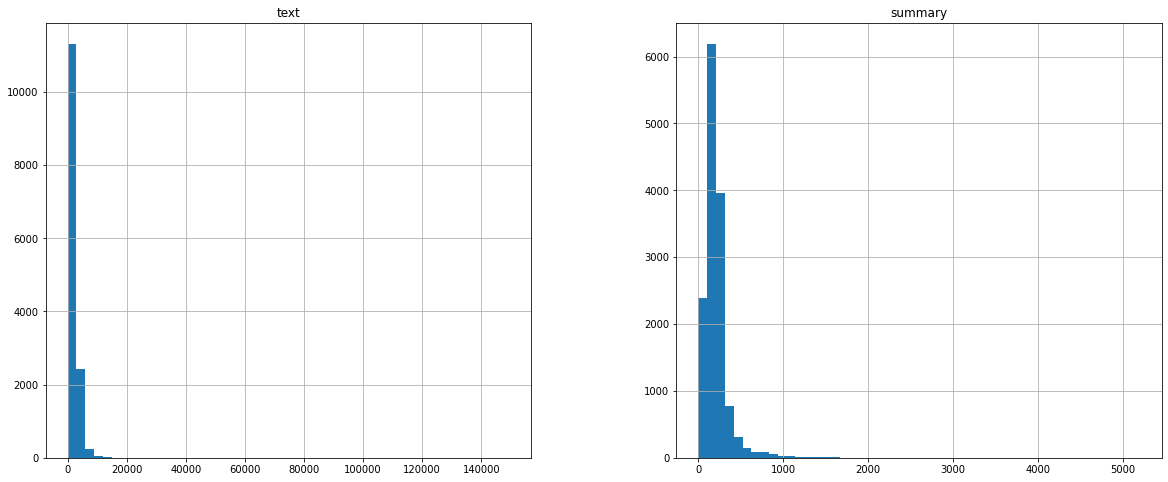

In [ ]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 50)
plt.show()

In [ ]:
#propotion of length of summaries
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=400):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9383406484496672


In [ ]:
#propotion of length of summaries
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=4000):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9085374486761999


In [ ]:
data.head()

,Unnamed: 0,Text,Summary,cleaned_text,cleaned_summary
0,1,"contrast to the lengthy, often redundant, genomes of higher organisms, the genomes of viruses are extremely efficient in the encoding of their genes. Where mammalian genomes, for example, possess...","e smallest known biological organisms are, by far, the viruses. One of the unique adaptations that many viruses have aquired is the compression of the genes in their genomes. In this paper we stud...",contrast lengthy often redundant genomes higher organisms genomes viruses extremely efficient encoding genes mammalian genomes example possess lengthy introns code genes given segment viral genome...,smallest known biological organisms are by far the viruses one of the unique adaptations that many viruses have aquired is the compression of the genes in their genomes in this paper we study form...
1,3,"e human respiratory viruses include adenovirus, bocavirus, human coronaviruses, enterovirus, influenza viruses, human metapneumovirus, parainfluenza virus, respiratory syncytial virus, and rhinovi...","7,772 laboratory-confirmed cases of respiratory viral infection among hospitalized patients, 22.8% were categorized as having hospital-acquired infection. The overall incidence of hospital-acquir...",human respiratory viruses include adenovirus bocavirus human coronaviruses enterovirus influenza viruses human metapneumovirus parainfluenza virus respiratory syncytial virus rhinovirus although r...,laboratory confirmed cases of respiratory viral infection among hospitalized patients were categorized as having hospital acquired infection the overall incidence of hospital acquired respiratory ...
2,4,"s pathologies infectieuses respiratoires sont fréquemment rencontrées dans la communauté et généralement de gravité légère ou modérée. Les agents responsables sont, dans la plupart des cas, de typ...","çu et accepté le 7 février 2004Les infections virales respiratoires communautaires sont fréquentes et le plus souvent bénignes. Beaucoup d'agents différents comme les virus influenza, ou para-infl...",pathologies infectieuses respiratoires sont fr quemment rencontr es dans la communaut et ralement de gravit ou mod les agents responsables sont dans la plupart des cas de type viral avec parmi eux...,et accept le vrier les infections virales respiratoires communautaires sont fr quentes et le plus souvent nignes beaucoup agents diff rents comme les virus influenza ou para influenza le virus res...
3,9,"ronavirus disease-2019 (COVID- 19) , caused by severe acute respiratory distress syndrome-coronavirus-2 (SARS-CoV-2), was initially reported in December 2019 as pneumonia with unknown etiology in ...","e World Health Organization recognized SARS-CoV-2 as a public health concern and declared it as a pandemic on March 11, 2020. Over 12 million people have been affected across several countries sin...",ronavirus disease caused severe acute respiratory distress syndrome coronavirus initially reported december pneumonia unknown etiology wuhan city china world health organization recognized sars co...,world health organization recognized sars cov as public health concern and declared it as pandemic on march over million people have been affected across several countries since it was first recog...
4,10,decins Sans Frontières (MSF) is one of the world's leading humanitarian medical organizations. It provides emergency medical assistance to populations in danger in more than 70 countries. The foun...,ckground: Médecins Sans Frontières (MSF) is one of the world's leading humanitarian medical organizations. The increased emphasis in MSF on research led to the creation of an ethics review board (...,decins sans fronti res one world leading humanitarian medical organizations provides emergency medical assistance populations danger countries foundational animating values msf humanitarian medica...,ckground decins sans fronti res is one of the world leading humanitarian medical organizations the increased em

In [ ]:
#**change to fit data set**
max_text_len=4000
max_summary_len=400 # this should be 100

In [ ]:
#selecting summaries of desired length
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

Remember to add the **START** and **END** special tokens at the beginning and end of the summary. Here, I have chosen **sostok** and **eostok** as START and END tokens

**Note:** Be sure that the chosen special tokens never appear in the summary

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [ ]:
df['text']

0        contrast lengthy often redundant genomes higher organisms genomes viruses extremely efficient encoding genes mammalian genomes example possess lengthy introns code genes given segment viral genome...
1        human respiratory viruses include adenovirus bocavirus human coronaviruses enterovirus influenza viruses human metapneumovirus parainfluenza virus respiratory syncytial virus rhinovirus although r...
2        ronavirus disease caused severe acute respiratory distress syndrome coronavirus initially reported december pneumonia unknown etiology wuhan city china world health organization recognized sars co...
3        decins sans fronti res one world leading humanitarian medical organizations provides emergency medical assistance populations danger countries foundational animating values msf humanitarian medica...
4        incidence health care associated infection caused multidrug resistant bacteria gradually risen last decade especially immunocompromised patients common cau

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.3,random_state=0,shuffle=True) 

# Tokenizer

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 64.44718611646404
Total Coverage of rare words: 1.1043098474954807


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

65127

# Summary Tokenizer

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 72.58688919476944
Total Coverage of rare words: 3.918900986573716


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [ ]:
#y_voc size seems too small.
#first try increasing number of articles
y_voc

12747

In [ ]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(8484, 8484)

Delete start and end tokens

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# The Model

In [ ]:
#can also use go_backwards = true for a layer or two

from keras import backend as K 
K.clear_session()

latent_dim = 200
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
bi_LSTM = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,
                             dropout=0.5,recurrent_dropout=0.5),merge_mode='concat' )(enc_emb)

encoder_output0, state_h0, state_c0, backward_h, backward_c =Bidirectional(LSTM(latent_dim, return_state=True), 
                               merge_mode="concat", name='bi')(bi_LSTM)

#econder_output0 = tf.expand_dims(encoder_output0, axis=-1)

encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.5)
encoder_outputs, state_h, state_c = encoder_lstm1(tf.expand_dims(encoder_output0, axis=-1)) #expanded dim of bi_lstm

#econder_output1 = tf.expand_dims(encoder_output1, axis=-1)

#encoder lstm 2
# encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.5,recurrent_dropout=0.5)
# encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output1)

#encoder lstm 3
#(consider bidirectinal layer pg. 546 in Geron)
# encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
# encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='elu')) #try elu***
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 4000, 100)    6512700     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 4000, 400),  481600      embedding[0][0]                  
__________________________________________________________________________________________________
bi (Bidirectional)              [(None, 400), (None, 961600      bidirectional[0][0]              
                                                                 bidirectional[0][1]   

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=5,batch_size=16, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/5
 78/530 [===>..........................] - ETA: 3:20:12 - loss: 4.7637

In [ ]:
#plot training
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Encoder/Decoder

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        #print('here')
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #print(sampled_token_index)

    #***for some reason the decoder breaks when sampled_token_index=0 t
        if(sampled_token_index == 0):sampled_token_index = sampled_token_index+1
    #****
        sampled_token = reverse_target_word_index[sampled_token_index]
        #sampled_token = reverse_source_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

In [ ]:
# from google.colab import files
# files.download('/var/log/colab-jupyter.log') 